In [1]:
'''Building up towards DARLA unsupervised + reinforcement learner'''
'''Going to start doing Tensorflow using variational autoencoder as an example.'''
'''Based on: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
and https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py'''

'Based on: https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf\nand https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py'

In [2]:
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
'''See: https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners'''

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.cm as cm # color maps

from sklearn.manifold import TSNE

/Users/adammarblestone/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/adammarblestone/anaconda/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


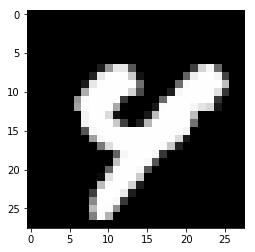

In [3]:
# Look at MNIST for a sec

def MNIST_row_as_image(row):
    arr1 = []
    for i in range(28):
        arr2 = []
        for j in range(28):
            arr2.append(row[28*i + j])
        arr1.append(arr2)
    return np.array(arr1)

image_example = MNIST_row_as_image(mnist.train.images[32171][:])

plt.figure()
plt.imshow(image_example, cmap = cm.Greys_r)

In [4]:
# Variational autoencoder

def run_variational_autoencoder(num_batches = 100000, batch_size = 10, learning_rate = 0.001, relative_weight = 0, fixed_seed = True):

    if fixed_seed:
        tf.set_random_seed(1234)
    
    # Define the sizes of the encoder layers
    first_layer_size = 50
    second_layer_size = 50
    latents_size = 6

    # This is the input image
    x = tf.placeholder(tf.float32, [None, 784]) # 784 is of course the size of the MNIST image

    # First encoder layer weights and biases
    W1 = tf.Variable(tf.random_normal([784, first_layer_size]))
    b1 = tf.Variable(tf.random_normal([first_layer_size]))

    # Second encoder layer weights and biases
    W2 = tf.Variable(tf.random_normal([first_layer_size, second_layer_size]))
    b2 = tf.Variable(tf.random_normal([second_layer_size]))

    # Third encoder layer weights and biases
    W3_means = tf.Variable(tf.random_normal([second_layer_size, latents_size]))
    b3_means = tf.Variable(tf.random_normal([latents_size]))
    
    W3_stds = tf.Variable(tf.random_normal([second_layer_size, latents_size]))
    b3_stds = tf.Variable(tf.random_normal([latents_size]))

    # Define the computational graph of the encoder
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(x,W1), b1))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1,W2), b2))
    
    # Generate the means and standard deviations for the latents
    layer3_means = tf.nn.tanh(tf.add(tf.matmul(layer2,W3_means), b3_means)) # Want to be close to a mean of zero
    layer3_stds = tf.nn.sigmoid(tf.add(tf.matmul(layer2,W3_stds), b3_stds)) # Want to be close to a std of 1
    
    # Sample as specified by the means and standard deviations
    samples_without_mean = tf.random_normal([latents_size], mean=0, stddev=1, dtype=tf.float32)  
    sampled_latents = layer3_means + (layer3_stds * samples_without_mean)
    layer3 = sampled_latents

    # Decoder layers are the same thing but in reverse
    W3_D = tf.Variable(tf.random_normal([latents_size, second_layer_size]))
    b3_D = tf.Variable(tf.random_normal([second_layer_size]))
    W2_D = tf.Variable(tf.random_normal([second_layer_size, first_layer_size]))
    b2_D = tf.Variable(tf.random_normal([first_layer_size]))
    W1_D = tf.Variable(tf.random_normal([first_layer_size, 784]))
    b1_D = tf.Variable(tf.random_normal([784]))

    layer3_D = tf.nn.sigmoid(tf.add(tf.matmul(layer3,W3_D), b3_D))
    layer2_D = tf.nn.sigmoid(tf.add(tf.matmul(layer3_D,W2_D), b2_D))
    layer1_D = tf.nn.sigmoid(tf.add(tf.matmul(layer2_D,W1_D), b1_D)) # Sigmoid for the last layer to put in [0,1]

    # Now define the loss function
    y_predicted = layer1_D
    y_true = x
    loss_reconstruction = tf.reduce_mean(tf.squared_difference(y_predicted,y_true)) # RMS reconstruction error in the pixel space
    loss_latent = 0.5 * tf.reduce_sum(tf.square(layer3_means) + tf.square(layer3_stds) - tf.log(tf.square(layer3_stds)) - 1)/batch_size  
    loss = loss_reconstruction + relative_weight * loss_latent # this includes a manual scaling parameter
    
    # Now train it
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        # writer = tf.summary.FileWriter('logs', sess.graph)

        sess.run(init)

        # train it
        print("Training...")
        for i in range(num_batches):
            if i % 10000 == 0:
                print("Batch %i" %i)
                
            batch_data, batch_labels = mnist.train.next_batch(batch_size)
            blank, loss_output, latent_codes = sess.run([optimizer, loss, layer3], feed_dict = {x:batch_data})
        
        # test it
        print("Testing...")
        batch_data, batch_labels = mnist.test.next_batch(5)
        reconstructed_image_examples, latent_codes = sess.run([y_predicted, layer3], feed_dict = {x:batch_data})
        for j in range(len(batch_data)):
            im = MNIST_row_as_image(reconstructed_image_examples[j])
            true_im = MNIST_row_as_image(batch_data[j])
            plt.figure()
            plt.imshow(im, cmap = cm.Greys_r)
            plt.figure()
            plt.imshow(true_im, cmap = cm.Greys_r)
        plt.show()

        # evaluate loss on the test set and show latent code space
        batch_data, batch_labels = mnist.test.next_batch(2000)
        l, latent_codes, means, stds = sess.run([loss, layer3, layer3_means, layer3_stds], feed_dict = {x:batch_data})
        X_embedded = TSNE(n_components=2).fit_transform(latent_codes)
        x = X_embedded[:,0]
        y = X_embedded[:,1]
        plt.figure()
        plt.title("Latent code space")
        plt.scatter(x,y, c = [np.argmax(k) for k in batch_labels], cmap=plt.get_cmap("Spectral"))
        plt.show()
        
        # show the first two latent code variables
        first_latent = [c[0] for c in latent_codes]
        second_latent = [c[1] for c in latent_codes]
        third_latent = [c[2] for c in latent_codes]
        plt.figure()
        plt.hist(first_latent, bins = 20, label = "first latent", range=[-2,2])
        plt.hist(second_latent, bins = 20, label = "second latent", range=[-2,2])
        plt.hist(third_latent, bins = 20, label = "third latent", range=[-2,2])
        plt.title("Histograms of first three latents")
        plt.legend()
        plt.show()

        plt.figure()
        plt.hist([m[0] for m in means], bins = 20, label = "first mean", range=[-2,2])
        plt.hist([m[1] for m in means], bins = 20, label = "second mean", range=[-2,2])
        plt.hist([m[2] for m in means], bins = 20, label = "third mean", range=[-2,2])
        plt.title("Histograms of first three means")
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.hist([m[0] for m in stds], bins = 20, label = "first std", range=[-2,2])
        plt.hist([m[1] for m in stds], bins = 20, label = "second std", range=[-2,2])
        plt.hist([m[2] for m in stds], bins = 20, label = "third std", range=[-2,2])
        plt.title("Histograms of first three stds")
        plt.legend()
        plt.show()
        
        print("Generation example...")
        for k in range(2):
            generated = sess.run([y_predicted], feed_dict = {layer3:[[0.5,0.5,0.5,0.5,0.5,0.5]]})
            generated_image = MNIST_row_as_image(generated[0][0])
            plt.figure()
            plt.imshow(generated_image, cmap = cm.Greys_r)
        for k in range(2):
            generated = sess.run([y_predicted], feed_dict = {layer3:[[-0.5,-0.5,0.1,0.1,-0.5,0.1]]})
            generated_image = MNIST_row_as_image(generated[0][0])
            plt.figure()
            plt.imshow(generated_image, cmap = cm.Greys_r)
        plt.show()
            
        print("Interpolation example...")
        print("First:")
        generated = sess.run([y_predicted], feed_dict = {layer3:[latent_codes[0]]})
        generated_image = MNIST_row_as_image(generated[0][0])
        plt.figure()
        plt.imshow(generated_image, cmap = cm.Greys_r)
        plt.show()
        print("Second:")
        generated = sess.run([y_predicted], feed_dict = {layer3:[latent_codes[1]]})
        generated_image = MNIST_row_as_image(generated[0][0])
        plt.figure()
        plt.imshow(generated_image, cmap = cm.Greys_r)
        plt.show()
        print("Interpolations:")
        for i in range(20):
            generated = sess.run([y_predicted], feed_dict = {layer3:[latent_codes[0] + (float(i)/20.0)*(latent_codes[1]-latent_codes[0])]})
            generated_image = MNIST_row_as_image(generated[0][0])
            plt.figure()
            plt.imshow(generated_image, cmap = cm.Greys_r)
        plt.show()
        
        print("Loss on test set: %f" % l)        
    
        print("________________________________\n\n")
        

        # writer.close() 
        # Use tensorboard --logdir="logs" --host=127.0.0.1 --port=6007 to see graph

60000 batches with KL divergence term weight 0.000000
Training...
Batch 0
Batch 10000
Batch 20000
Batch 30000
Batch 40000
Batch 50000
Testing...


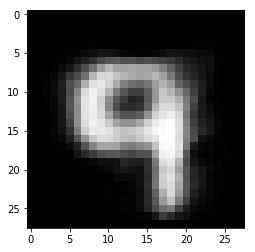

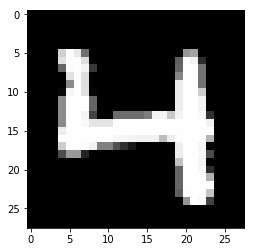

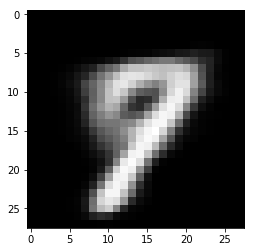

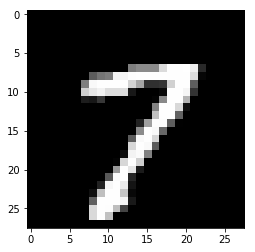

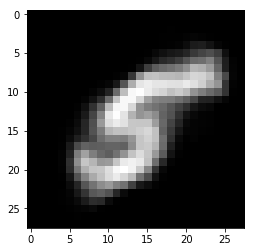

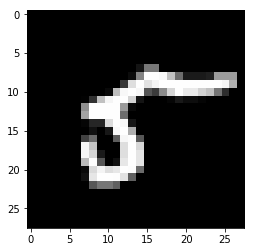

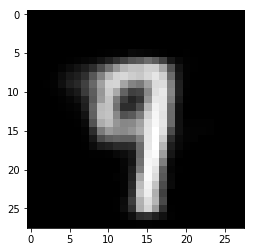

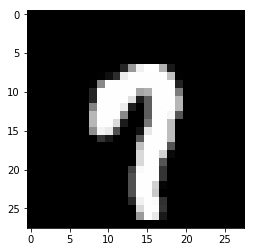

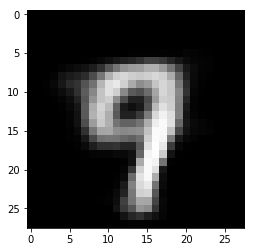

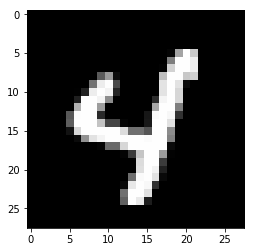

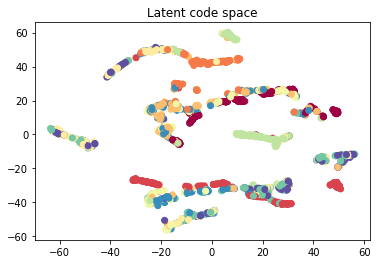

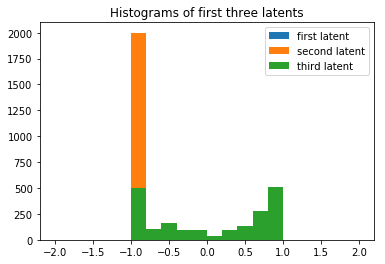

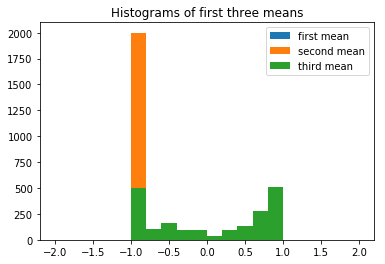

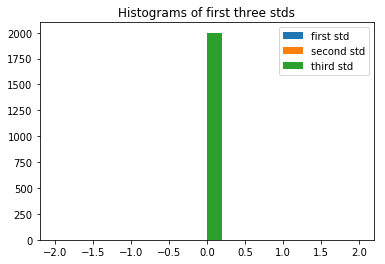

Generation example...


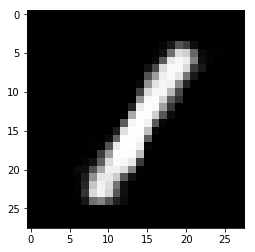

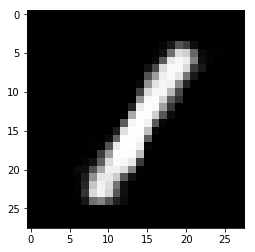

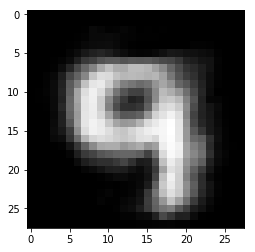

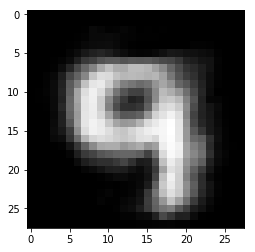

Interpolation example...
First:


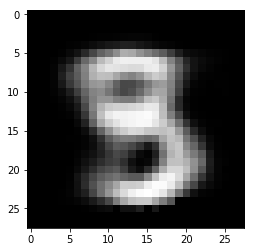

Second:


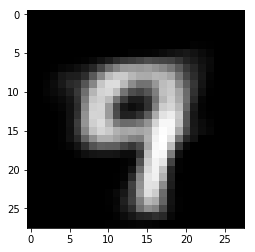

Interpolations:


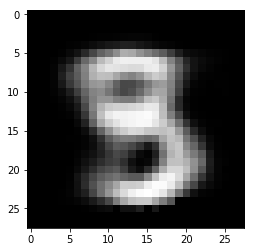

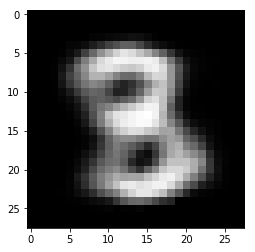

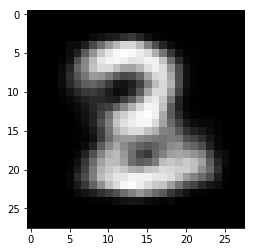

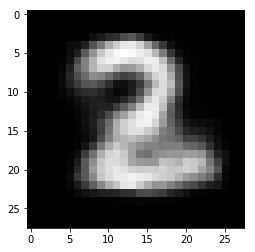

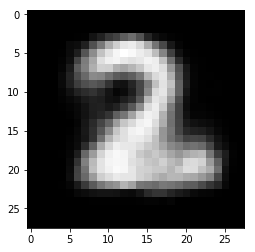

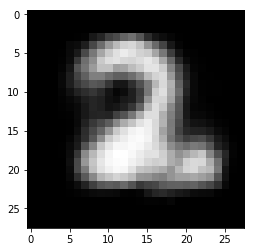

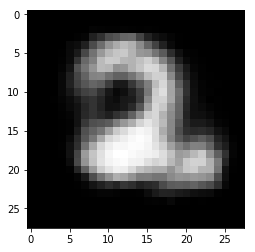

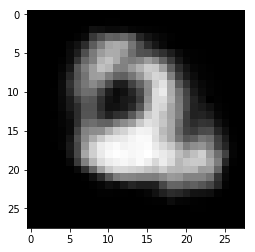

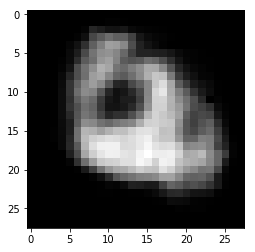

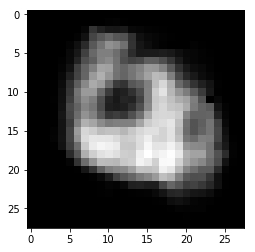

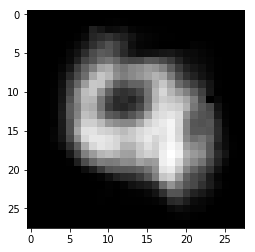

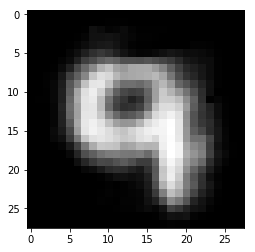

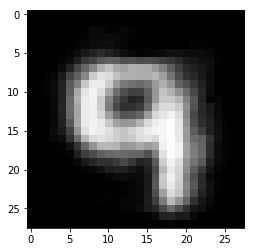

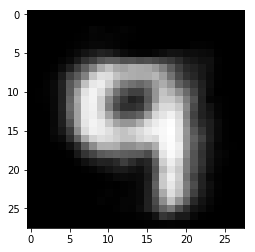

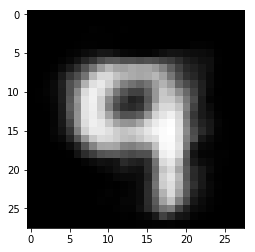

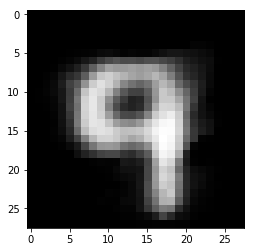

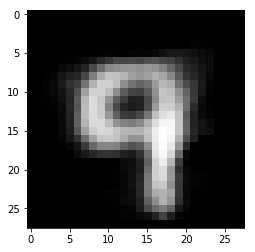

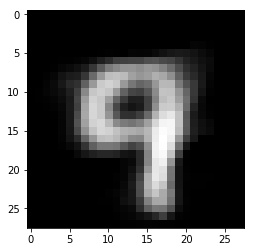

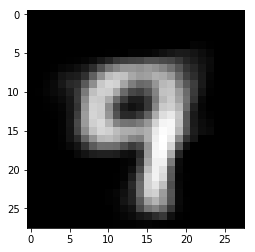

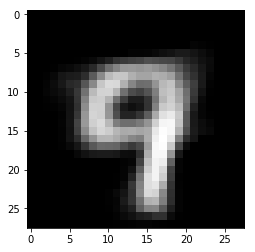

Loss on test set: 0.046387
________________________________


60000 batches with KL divergence term weight 0.000030
Training...
Batch 0
Batch 10000
Batch 20000
Batch 30000
Batch 40000
Batch 50000
Testing...


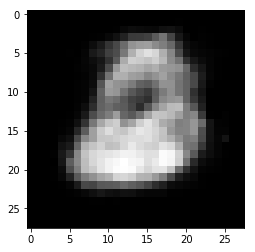

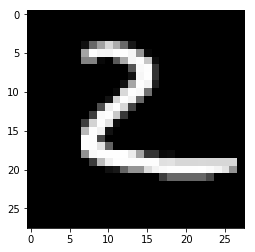

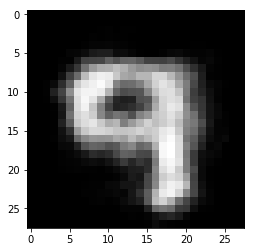

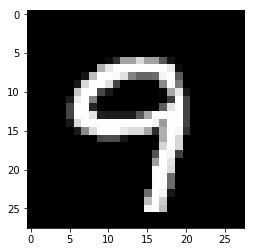

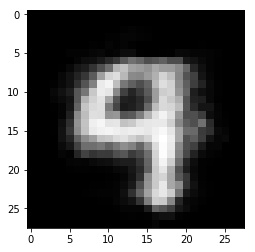

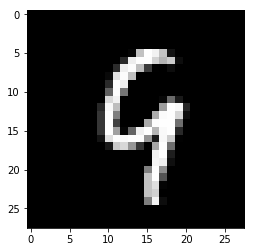

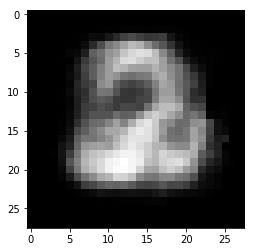

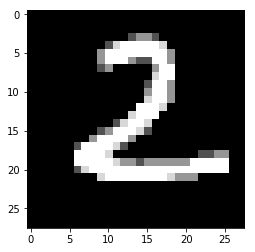

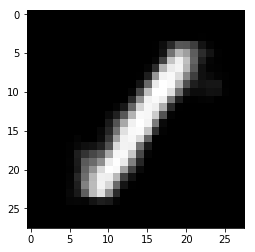

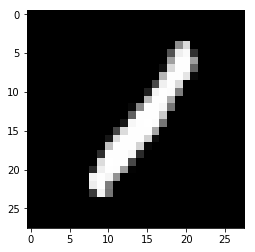

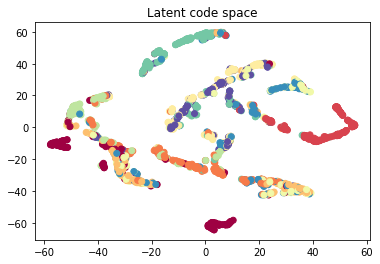

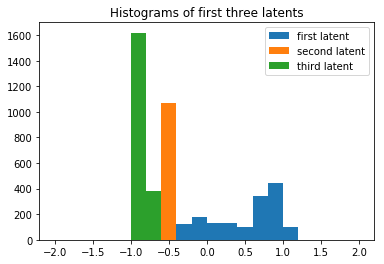

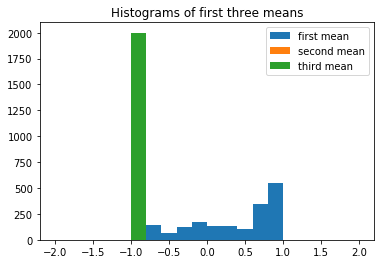

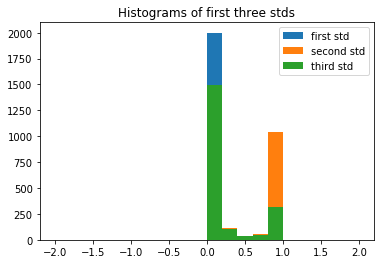

Generation example...


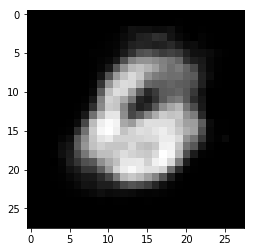

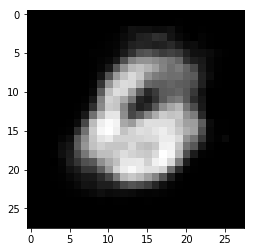

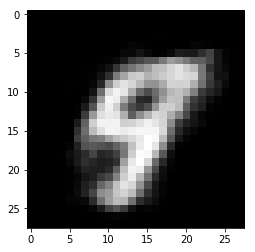

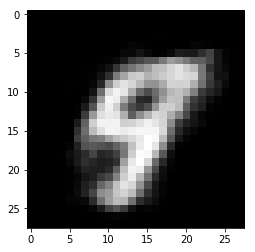

Interpolation example...
First:


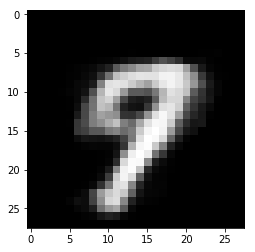

Second:


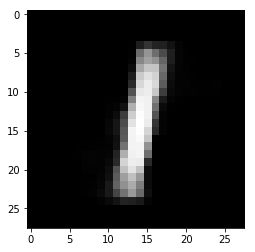

Interpolations:


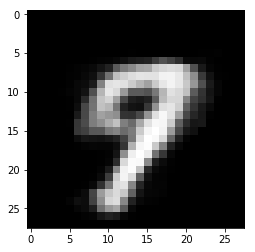

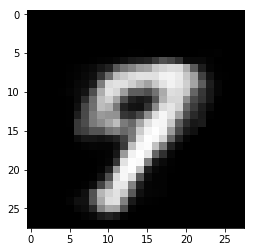

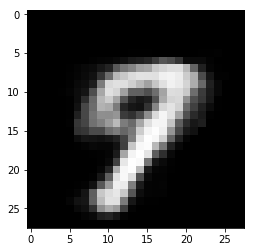

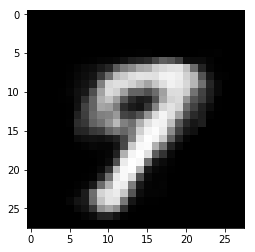

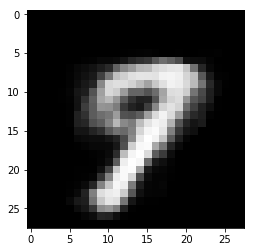

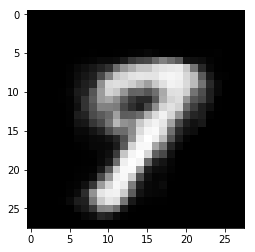

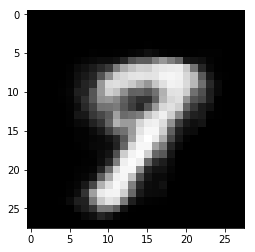

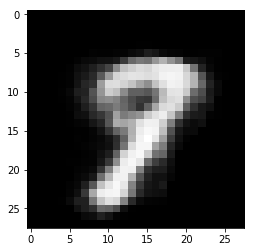

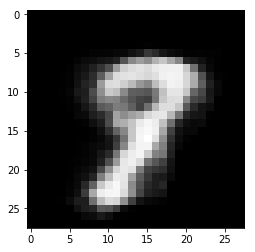

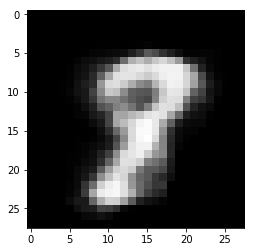

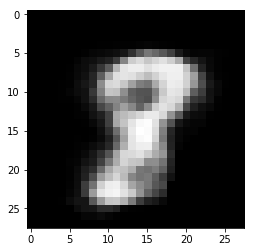

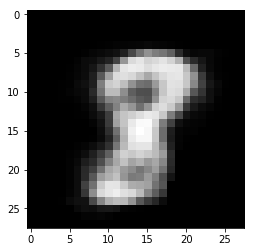

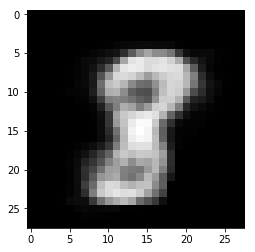

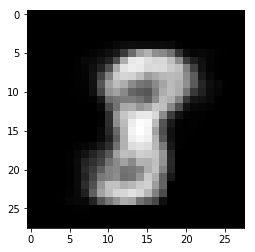

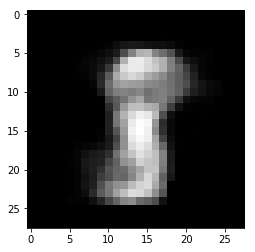

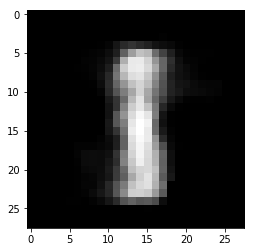

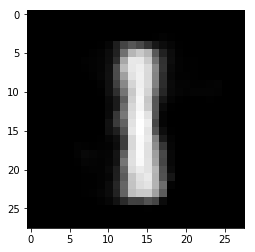

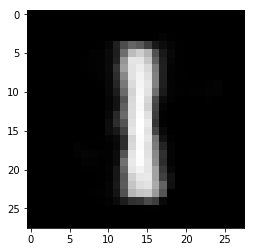

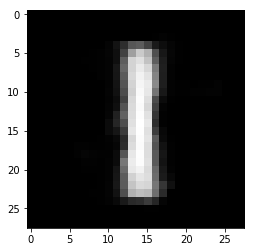

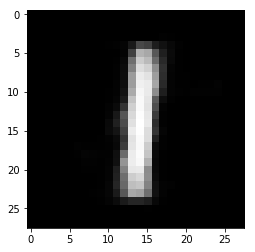

Loss on test set: 0.146991
________________________________




In [5]:
n_batches = 60000
rels = [0.0, 0.00003]

for i in range(len(rels)):

    print("%i batches with KL divergence term weight %f" %(n_batches, rels[i]))
    run_variational_autoencoder(num_batches = n_batches, batch_size = 10, learning_rate = 0.01, relative_weight = rels[i], fixed_seed = False)